## Практическое задание (vo_HW) Граур Андрей Константинович

### Задача:
Предлагаем вам решить практическое задание с использованием Transformer и сравнить полученные оценки качества.

### Критерии оценивания проекта:

- общее качество кода и следование PEP-8;
- использованы варианты архитектур, близкие к state of the art для данной задачи;
- произведен подбор гиперпараметров;
- использованы техники изменения learning rate (lr scheduler);
- использована адекватная задаче функция потерь;
- использованы техники регуляризации;
- корректно проведена валидация модели;
- использованы техники ensemble;
- использованы дополнительные данные;
- итоговое значение метрики качества > 0.7.

Ниже представлен скриншот с соревнования Kaggle с моим решением через рекурентные сети:
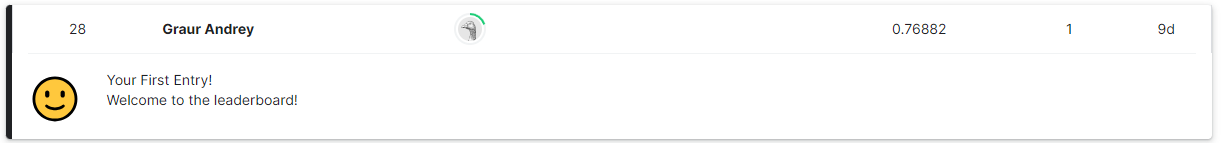

Как видно из скриншота, предыдущее решение имело итоговое значение метрики качества 0,7688. Теперь попробую решить эту задачу с помощью трансформера.

## 1) Импортирую необхоимдые мне зависимости

In [17]:
!pip install evaluate

In [18]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import nltk
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import re
from datasets import Dataset, DatasetDict
import datasets
from transformers import Trainer, TrainingArguments, set_seed
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import DataCollatorWithPadding
import evaluate
from transformers import EvalPrediction
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 2) Достаю данные

In [19]:
# Для Каггла
# train = pd.read_csv('/kaggle/input/unit-3-nlp-txt-classification/train.csv', index_col = 0)

# Для Колаба
# train = pd.read_csv('/content/sample_data/train.csv', index_col = 0)

# для локального ноутбука
train =  pd.read_csv('C:\\Users\\Andrew\\code\\mipt\\nlp\\dz1\\data\\train.csv', index_col = 0)
train = train.dropna()
train.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [20]:
# Для Каггла
# test = pd.read_csv('/kaggle/input/unit-3-nlp-txt-classification/test.csv')

# Для Колаба
# test = pd.read_csv('/content/sample_data/test.csv')

# для локального ноутбука
test =  pd.read_csv('C:\\Users\\Andrew\\code\\mipt\\nlp\\dz1\\data\\test.csv')
test.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


## 3) Проверяю данные и стараюсь их провалидировать и удалить лишнее 

In [38]:
# Чекаю отсутсвующие данные
train.isnull().sum()

Text         0
Sentiment    0
text         0
label        0
dtype: int64

In [39]:
# Чекаю неконсистентные данные
train[~train['Sentiment'].isin(['Positive', 'Neutral', 'Negative'])]

,Text,Sentiment,text,label
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,0
11,"Due to the Covid-19 situation, we have increas...",Extremely Positive,due to the covid 19 situation we have increase...,4
12,#horningsea is a caring community. LetÂs ALL ...,Extremely Positive,horningsea is a caring community letâ s all lo...,4
18,"Amazon Glitch Stymies Whole Foods, Fresh Groce...",Extremely Positive,amazon glitch stymies whole foods fresh grocer...,4
20,with 100 nations inficted with covid 19 th...,Extremely Negative,with 100 nations inficted with covid 19 the wo...,0
...,...,...,...,...
41138,HMU FOR PRICES!! Got great deals going right n...,Extremely Positive,hmu for prices got great deals going right now...,4
41142,@MajangChien @MTNSSD @MTNSSD is worst than COV...,Extremely Positive,majangchien mtnssd mtnssd is worst than covid ...,4
41148,UV light Sterilizer Sanitizer for your mask an...,Extremely Positive,uv light sterilizer sanitizer for your mask an...,4
41151,@MrSilverScott you are definitely my man. I fe...,Extremely Positive,mrsilverscott you are definitely my man i feel...,4


In [21]:
# Взял маппинг специальных знаков и аббривиатур отсюда: https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
     "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
       "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
      "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [22]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokenizer = nltk.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [23]:
#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [24]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text) 
    return text

In [25]:
def data_clean(text):
        text_lower = text.lower()
        text_lower = re.sub(re.compile('http\S+'), '', text_lower).strip()
        text_lower = remove_emoji(text_lower)
        text_lower = re.sub(re.compile('\<(.*?)\>'), '', text_lower).strip()
        text_lower = re.sub(re.compile('[^\w\s]'), ' ', text_lower).strip()
        text_lower = denoise_text(text_lower)
        text_lower = convert_abbrev_in_text(text_lower)
        return text_lower

def label_coversion(text):
    if text == 'Extremely Negative':
        return 0
    elif text == 'Negative':
        return 1
    elif text == 'Neutral':
        return 2
    elif text == 'Positive':
        return 3
    else:
        return 4

In [26]:
train['text'] = train['Text'].apply(lambda x: data_clean(x))
test_upd = test[['Text']]
test_upd['label'] = ''
test_upd['text'] = test_upd['Text'].apply(lambda x: data_clean(x))
train['label'] = train['Sentiment'].apply(lambda x: label_coversion(x))
df_train, df_valid= train_test_split(train[['text', 'label']], test_size=0.2)
test_upd = test_upd[['text', 'label']]

In [27]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop = True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop = True)),
    'test': Dataset.from_pandas(test_upd)
    })
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3798
    })
})

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
def preprocess_data(examples):
     
    encoding = tokenizer(examples['text'])
    return encoding

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True)

encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['text'])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/32924 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3798
    })
})

# Finetune Roberta-base модели

Загрузим модель, зададим список параметров для finetune. В цикле переберем параметры, будем сравнивать по метрике MCC. Лучшая модель будет использована для генерации предсказаний.
Буду использовать Trainer для обучения, в нем есть возможность сохранять и использовать лучшую модель.

**For info:** значение для MCC находится в диапазоне от -1 до 1, где:

<li> -1 указывает на полное несоответствие между предсказанными классами и фактическими классами
<li> 0 является синонимом полностью случайного угадывания
<li> 1 указывает на полное соответствие между предсказанными классами и фактическими классами

In [30]:
MAX_LEN = 160
N_EPOCHS = 5
LR_VALUES = (2e-5, 5e-5)
DECAY_VALUES = (1e-4, 0.1)
BATCH_SIZES = (16, 32)

In [31]:
ACCURACY = evaluate.load("accuracy")
MCC = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    preds = np.argmax(preds, axis=1)

    acc_result = ACCURACY.compute(predictions=preds, references=p.label_ids)
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    result = {"accuracy": acc_result["accuracy"], "mcc": mcc_result["matthews_correlation"]}

    return result

In [32]:
metrics = pd.DataFrame()

for i, learning_rate in enumerate(LR_VALUES):
    for j, weight_decay in enumerate(DECAY_VALUES):
        for k, batch_size in enumerate(BATCH_SIZES):

                
                model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels = 5)


                print(f'Log: training for l_r:{learning_rate}, w_d:{weight_decay}, batch_size:{batch_size}...')
                training_args = TrainingArguments(
                    output_dir=f"Roberta",
                    overwrite_output_dir=True,
                    evaluation_strategy="epoch",
                    per_device_train_batch_size=batch_size,
                    per_device_eval_batch_size=batch_size,
                    learning_rate=learning_rate,
                    weight_decay=weight_decay,
                    num_train_epochs=N_EPOCHS,
                    warmup_ratio=0.1,
                    optim="adamw_torch",
                    save_strategy="no",
                    save_total_limit=1,
                    group_by_length=True,
                    report_to="none"
                    
                )

                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=encoded_dataset['train'],
                    eval_dataset=encoded_dataset['valid'],
                    compute_metrics=compute_metrics,
                    tokenizer=tokenizer,
                    data_collator=data_collator,
                )

                train_result = trainer.train()
                print("train", train_result.metrics)


                valid_predictions = trainer.predict(test_dataset=encoded_dataset['valid'])
                print("valid", valid_predictions.metrics)

                metrics = pd.concat([metrics, pd.DataFrame([{'learn_rate': learning_rate,
                           'weight_decay': weight_decay,
                           'batch_size': batch_size,                                
                           'accuracy': valid_predictions.metrics["test_accuracy"],
                           'mcc': valid_predictions.metrics["test_mcc"]
                           
                    
                }])], ignore_index=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:2e-05, w_d:0.0001, batch_size:16...


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.708300,0.628048,0.774997,0.715380
2,0.520700,0.606636,0.782651,0.726921
3,0.394900,0.480710,0.838416,0.794614
4,0.311100,0.574252,0.829182,0.785355
5,0.242100,0.594556,0.841575,0.799645


train {'train_runtime': 2445.7789, 'train_samples_per_second': 67.308, 'train_steps_per_second': 4.207, 'total_flos': 3489986707979568.0, 'train_loss': 0.5052516481271638, 'epoch': 5.0}


valid {'test_loss': 0.5945557355880737, 'test_accuracy': 0.841574535293403, 'test_mcc': 0.7996446465400651, 'test_runtime': 45.3202, 'test_samples_per_second': 181.619, 'test_steps_per_second': 11.364}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:2e-05, w_d:0.0001, batch_size:32...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.849200,0.726530,0.721055,0.649445
2,0.578300,0.584729,0.787754,0.733144
3,0.437800,0.540647,0.809865,0.761087
4,0.369800,0.601061,0.804034,0.755204
5,0.300800,0.557528,0.822865,0.776535


train {'train_runtime': 9744.4454, 'train_samples_per_second': 16.894, 'train_steps_per_second': 0.528, 'total_flos': 3502188811836336.0, 'train_loss': 0.5681903516585903, 'epoch': 5.0}


valid {'test_loss': 0.5575283169746399, 'test_accuracy': 0.8228647794921637, 'test_mcc': 0.7765354202488424, 'test_runtime': 546.7819, 'test_samples_per_second': 15.054, 'test_steps_per_second': 0.472}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:2e-05, w_d:0.1, batch_size:16...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.708200,0.633622,0.765399,0.702681
2,0.526700,0.606493,0.778763,0.721975
3,0.399900,0.460131,0.844976,0.803171
4,0.301100,0.541099,0.837079,0.794552
5,0.243600,0.586262,0.844247,0.803018


train {'train_runtime': 2440.7832, 'train_samples_per_second': 67.446, 'train_steps_per_second': 4.216, 'total_flos': 3489986707979568.0, 'train_loss': 0.5054510667094684, 'epoch': 5.0}


valid {'test_loss': 0.5862619280815125, 'test_accuracy': 0.8442473575507229, 'test_mcc': 0.803017857246452, 'test_runtime': 45.2332, 'test_samples_per_second': 181.968, 'test_steps_per_second': 11.385}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:2e-05, w_d:0.1, batch_size:32...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.853600,0.793223,0.687401,0.613153
2,0.576300,0.595601,0.785567,0.730699
3,0.435900,0.538057,0.812538,0.764490
4,0.369100,0.589722,0.801482,0.751883
5,0.296900,0.545471,0.826631,0.781234


train {'train_runtime': 9498.5691, 'train_samples_per_second': 17.331, 'train_steps_per_second': 0.542, 'total_flos': 3502188811836336.0, 'train_loss': 0.5677475650294297, 'epoch': 5.0}


valid {'test_loss': 0.5454705953598022, 'test_accuracy': 0.826631029036569, 'test_mcc': 0.7812340624093196, 'test_runtime': 547.5357, 'test_samples_per_second': 15.033, 'test_steps_per_second': 0.471}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:5e-05, w_d:0.0001, batch_size:16...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.718300,0.622482,0.779006,0.720219
2,0.521300,0.598726,0.799174,0.746318
3,0.371400,0.492163,0.832463,0.787301
4,0.265100,0.614008,0.834528,0.792472
5,0.190500,0.627940,0.854088,0.815328


train {'train_runtime': 2442.1513, 'train_samples_per_second': 67.408, 'train_steps_per_second': 4.213, 'total_flos': 3489986707979568.0, 'train_loss': 0.4758210055218725, 'epoch': 5.0}


valid {'test_loss': 0.6279397010803223, 'test_accuracy': 0.8540882031344915, 'test_mcc': 0.8153283305331707, 'test_runtime': 45.1407, 'test_samples_per_second': 182.341, 'test_steps_per_second': 11.409}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:5e-05, w_d:0.0001, batch_size:32...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.777200,0.674052,0.752278,0.687632
2,0.513700,0.568242,0.801118,0.749763
3,0.360100,0.489264,0.840724,0.798152
4,0.279800,0.544384,0.824323,0.780314
5,0.183700,0.534967,0.849350,0.809572


train {'train_runtime': 10445.307, 'train_samples_per_second': 15.76, 'train_steps_per_second': 0.493, 'total_flos': 3502188811836336.0, 'train_loss': 0.47393950897009196, 'epoch': 5.0}


valid {'test_loss': 0.5349667072296143, 'test_accuracy': 0.8493500182237881, 'test_mcc': 0.8095721399223221, 'test_runtime': 546.8861, 'test_samples_per_second': 15.051, 'test_steps_per_second': 0.472}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:5e-05, w_d:0.1, batch_size:16...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.721600,0.635666,0.764670,0.704073
2,0.518900,0.529281,0.811809,0.761795
3,0.371400,0.528360,0.825902,0.779038
4,0.257100,0.550703,0.830033,0.787567
5,0.184700,0.622026,0.857976,0.819983


train {'train_runtime': 2444.5706, 'train_samples_per_second': 67.341, 'train_steps_per_second': 4.209, 'total_flos': 3489986707979568.0, 'train_loss': 0.47216979528191716, 'epoch': 5.0}


valid {'test_loss': 0.6220256686210632, 'test_accuracy': 0.8579759445996841, 'test_mcc': 0.8199833348972159, 'test_runtime': 45.3349, 'test_samples_per_second': 181.56, 'test_steps_per_second': 11.36}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:5e-05, w_d:0.1, batch_size:32...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.782300,0.716300,0.731867,0.664153
2,0.514400,0.500793,0.822136,0.773908
3,0.358800,0.453493,0.845827,0.804081
4,0.262100,0.528665,0.835135,0.792490
5,0.174000,0.558424,0.848257,0.808041


train {'train_runtime': 6750.1244, 'train_samples_per_second': 24.388, 'train_steps_per_second': 0.762, 'total_flos': 3502188811836336.0, 'train_loss': 0.4706459475444056, 'epoch': 5.0}


valid {'test_loss': 0.5584237575531006, 'test_accuracy': 0.8482565909367027, 'test_mcc': 0.8080409645805502, 'test_runtime': 114.5832, 'test_samples_per_second': 71.834, 'test_steps_per_second': 2.252}


In [33]:
metrics.sort_values(by = 'mcc', ascending = False)

,learn_rate,weight_decay,batch_size,accuracy,mcc
6,0.00005,0.1000,16,0.857976,0.819983
4,0.00005,0.0001,16,0.854088,0.815328
5,0.00005,0.0001,32,0.849350,0.809572
7,0.00005,0.1000,32,0.848257,0.808041
2,0.00002,0.1000,16,0.844247,0.803018
0,0.00002,0.0001,16,0.841575,0.799645
3,0.00002,0.1000,32,0.826631,0.781234
1,0.00002,0.0001,32,0.822865,0.776535


# Выбор лучшей модели и submission prediction

Итак, получается, что лучшие результаты показывает иоедь с более низким learning rate и более высоким уровнем регуляризации (weight decay 0,1). Воспользуемся этой модель для формирования предсказаний на тестовой выборке.

In [34]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Roberta",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none"

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.685400,0.597737,0.783623,0.725146
2,0.476900,0.480439,0.829790,0.784044
3,0.309700,0.501087,0.842789,0.801249


TrainOutput(global_step=6174, training_loss=0.596876014657572, metrics={'train_runtime': 1466.4041, 'train_samples_per_second': 67.357, 'train_steps_per_second': 4.21, 'total_flos': 2094502638432960.0, 'train_loss': 0.596876014657572, 'epoch': 3.0})

In [35]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

In [36]:
sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )